In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.timeseries import LombScargle

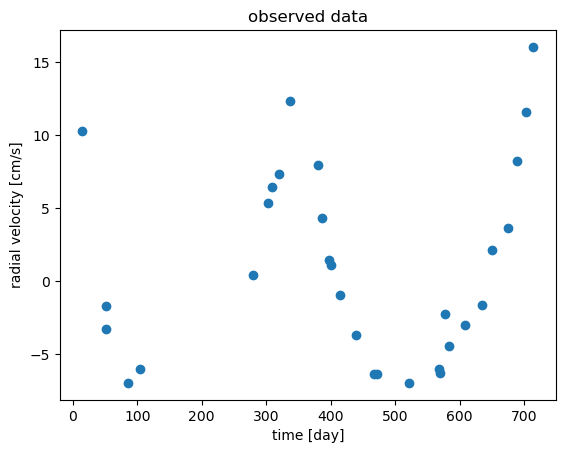

In [2]:
#観測データ
#観測時間[day]
t_obs = np.array([1.475943013143777449e+01, 5.185632248445747194e+01, 5.185632248445747194e+01, 8.634033088432124714e+01, 1.046478998086038672e+02, 2.799123087428177428e+02, 3.027032161930821985e+02, 3.092680035174004161e+02, 3.194386642217655208e+02, 3.368799344446402415e+02, 3.809492748775522841e+02, 3.860932914196202432e+02, 3.977647235877346930e+02, 4.006338578669470394e+02, 4.146725295985705770e+02, 4.400172645322999756e+02, 4.671423455690924129e+02, 4.715027025386589230e+02, 5.220882374518662346e+02, 5.680544281933908906e+02, 5.697862986891125274e+02, 5.779592778003451485e+02, 5.833857518782082252e+02, 6.078124872499947742e+02, 6.351088682201780102e+02, 6.509942905709182241e+02, 6.756855459536425315e+02, 6.896083094461962446e+02, 7.034738151657512617e+02, 7.143913898299176708e+02])
#観測視線速度[cm/s]
rv_obs = np.array([1.029276526418392912e+01, -3.249059287763180759e+00, -1.700108753335274336e+00, -6.955230249810869125e+00, -5.988878466163186864e+00, 4.491811842698901769e-01, 5.343830234167499249e+00, 6.473086308887705087e+00, 7.339880010333093452e+00, 1.237654249070353174e+01, 7.930107959072777213e+00, 4.327858815767007705e+00, 1.437625811081091776e+00, 1.084282895994354012e+00, -9.271728835113239864e-01, -3.695967346343064897e+00, -6.373664267627315638e+00, -6.368450716381578225e+00, -6.976346898853369893e+00, -6.050366999996878548e+00, -6.267611406635054117e+00, -2.262851651405441089e+00, -4.471246878319825591e+00, -3.020041449722365989e+00, -1.646300434931433854e+00, 2.140575039752232289e+00, 3.668134396731464797e+00, 8.258289731291169389e+00, 1.159576134374126077e+01, 1.605189275361949797e+01])

#プロット
plt.scatter(t_obs, rv_obs)
plt.title("observed data")
plt.xlabel("time [day]")
plt.ylabel("radial velocity [cm/s]")
plt.show()

Lomb-Scargle法による最も可能性の高い周期: 368.2273472097263 day


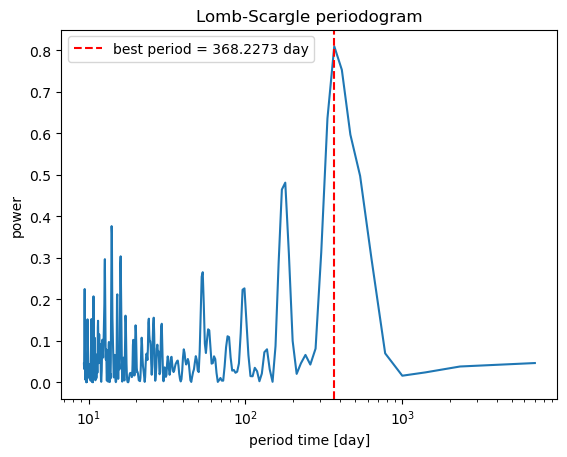

In [3]:
# Lomb-Scargle法でP
frequency, power = LombScargle(t_obs, rv_obs).autopower()

best_period = 1.0 / frequency[np.argmax(power)]
print(f"Lomb-Scargle法による最も可能性の高い周期: {best_period} day")

#プロット
plt.figure()
plt.plot(1.0 / frequency, power, "-")
plt.axvline(best_period, color='r', linestyle='--', label=f'best period = {best_period:.4f} day')
plt.title("Lomb-Scargle periodogram")
plt.xlabel("period time [day]")
plt.ylabel("power")
plt.xscale("log") 
plt.legend()
plt.show()

フィッティング結果
軌道周期 P     = 365.2058 ± 2.1092 [day]
速度半振幅 K   = 11.3782 ± 0.6033 [cm/s]
離心率 e       = 0.4756 ± 0.0310
近日点引数 ω  = 0.3632 ± 0.0588 [rad]
近日点通過時刻 T0 = -1.9677 ± 3.0766 [day]
システム速度 Vsys = -0.2454 ± 0.2646 [cm/s]


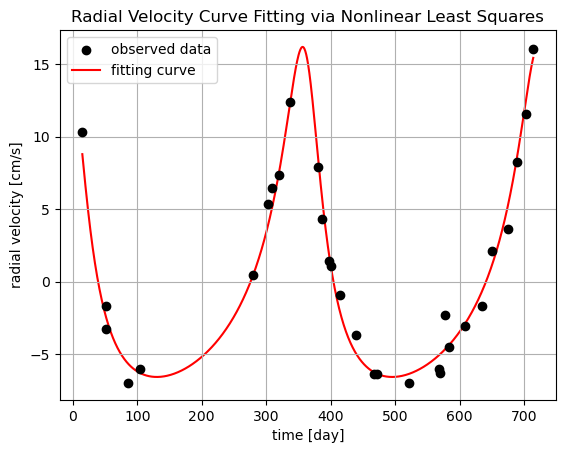


残差から推定したノイズの標準偏差 σ = 1.0110 [cm/s]


In [4]:
#最小二乗フィッティングでP,K,e,ω,Vsys,T0
from scipy.optimize import curve_fit

#ケプラー方程式を解く（ニュートン法）
def solve_kepler(mean_anomaly, eccentricity):
    E = mean_anomaly
    for _ in range(20):
        E = E - (E - eccentricity * np.sin(E) - mean_anomaly) / (1 - eccentricity * np.cos(E))
    return E

#フィッティングのモデル関数
def radial_velocity_model(t, P, K, e, omega, T0, Vsys):

    #平均近点角M
    M = 2 * np.pi * (t - T0) / P

    #離心近点角E
    E_solver_vec = np.vectorize(solve_kepler)
    E = E_solver_vec(M, e)

    #真近点角f
    f = 2 * np.arctan2(
        np.sqrt(1 + e) * np.sin(E / 2),
        np.sqrt(1 - e) * np.cos(E / 2)
    )

    #視線速度Vr
    Vr = K * (np.cos(f + omega) + e * np.cos(omega)) + Vsys

    return Vr

#パラメータ推定初期値
P_guess = best_period                 #Lomb-Scargle法で見つけた
K_guess = (rv_obs.max() - rv_obs.min()) / 2  #元データの振幅の半分
e_guess = 0.1                   #とりあえず少しだけ歪んでいると仮定
omega_guess = 0.0               #とりあえず0
T0_guess = 0.0                  #とりあえず0
Vsys_guess = np.mean(rv_obs)    #データの平均
p0 = [P_guess, K_guess, e_guess, omega_guess, T0_guess, Vsys_guess]

#フィッティング
popt, pcov = curve_fit(radial_velocity_model, t_obs, rv_obs, p0=p0)

#求められたパラメータ
P_fit, K_fit, e_fit, omega_fit, T0_fit, Vsys_fit = popt

#パラメータの誤差
perr = np.sqrt(np.diag(pcov))
P_err, K_err, e_err, omega_err, T0_err, Vsys_err = perr

#出力
print("フィッティング結果")
print(f"軌道周期 P     = {P_fit:.4f} ± {P_err:.4f} [day]")
print(f"速度半振幅 K   = {K_fit:.4f} ± {K_err:.4f} [cm/s]")
print(f"離心率 e       = {e_fit:.4f} ± {e_err:.4f}")
print(f"近日点引数 ω  = {omega_fit:.4f} ± {omega_err:.4f} [rad]")
print(f"近日点通過時刻 T0 = {T0_fit:.4f} ± {T0_err:.4f} [day]")
print(f"システム速度 Vsys = {Vsys_fit:.4f} ± {Vsys_err:.4f} [cm/s]")

#プロット
plt.figure()
plt.scatter(t_obs, rv_obs, color='k', label='observed data', zorder=2)

t_fit = np.linspace(t_obs.min(), t_obs.max(), 1000)
rv_fit = radial_velocity_model(t_fit, *popt)
plt.plot(t_fit, rv_fit, 'r-', label='fitting curve', zorder=1)

plt.title("Radial Velocity Curve Fitting via Nonlinear Least Squares")
plt.xlabel("time [day]")
plt.ylabel("radial velocity [cm/s]")
plt.legend()
plt.grid(True)
plt.show()

residual = rv_obs - radial_velocity_model(t_obs, *popt)
sigma_est = np.std(residual)

print(f"\n残差から推定したノイズの標準偏差 σ = {sigma_est:.4f} [cm/s]")